## Scientific Computing --  Homework Set 10 (Entropy and Allocation)
* Renke Cai
* renke.cai@nyu.edu

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import fmt
import me
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


## Problem 1

Use the dual objective discussed in class to solve the following maximum entropy optimization problems.

Find the the maximum entropy (ME) distribution without any prior distributions (equivalent to uniform priors) with the following constraints:

1. with constraints of $\mathbb{E}[x] = 0$ and $\mathbb{E}[x^2] = 1$; show that the resulting distribution is indeed normal.
2. does your ME distribution from #1 depend on the range of the discrete samples? for example, do the resulting ME distribution look normal if the discrete samples span only [-1.5, 1.5]? explain why.
3. define a transformation of $y = e^x$, where $y$ is a lognormal distribution if $x$ is normal. Solve the ME problem using equal spaced samples in $y$ with the constraint $\mathbb{E}[\log(y)]=0$ and $\mathbb{E}[\log^2(y)] = 1$, and check if the resulting $y$ distribution is lognormal (it is not). 
4. Explain why your step 3 do not result in a lognormal distribution.
5. [optional] Can you adjust the prior distribution in #3 to reproduce the similar results as in #1 without changing the equal-spaced sampling in $y$?

Hint: 
* this problem illustrate that the importance of the prior distributions.
* You can use the me package as part of the class library to solve this problem. You will get extra credit if you can implement your own version of the ME optimizations. If you choose to implement your own, beware that the exp() function may overflow, so you need to apply a cap before calling exp().
* for #1. you should try a discretization of a wide range first, for example (-6, 6) with small sampling steps
* the Q-Q plot is an effective way to show whether two distributions are similar. Google search Q-Q plot if you don't know what it is.

### Solution
**(1)** With constraints of $\mathbb{E}[x] = 0$ and $\mathbb{E}[x^2] = 1$, we see that the resulting distribution is indeed normal. This is illustrated by Q-Q plot.

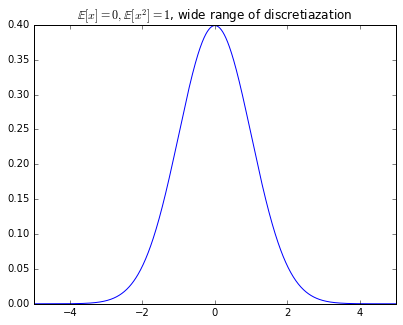

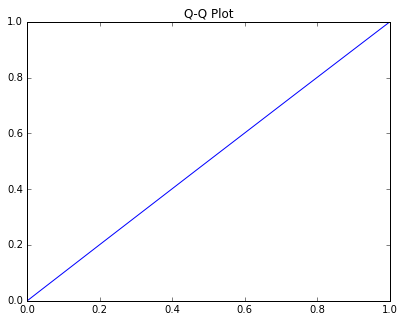

In [12]:
dx = .01
x = np.arange(-5., 5., dx)
a = np.array([x, x*x])
u = np.array([0., 1.])
e = np.array([0., 0.])
q = np.ones(np.size(x))/len(x)
dual = me.MaxEntDual(q, a, u, e)

figure(figsize=[6.5, 5])
res = minimize(dual.dual, np.zeros(len(u)), jac=dual.grad, method="BFGS")
plot(x, dual.dist(res.x)/dx)
xlim(-5, 5)
title('$\mathbb{E}[x] = 0, \mathbb{E}[x^2] = 1$, wide range of discretiazation');

dual_cdf = np.zeros(size(x))
for i in range(size(x)):
    dual_cdf[i:] += dual.dist(res.x)[i]

figure(figsize=[6.5, 5])
norm_cdf = norm.cdf(x)
plot(norm_cdf, dual_cdf)
ylim(0, 1)
title('Q-Q Plot');


**(2)** Since the range is small, the ***exploding*** shape is also abot to make the area under density function to be $1$. If the range is large enough, then only the bell curve shape can make the area converge.

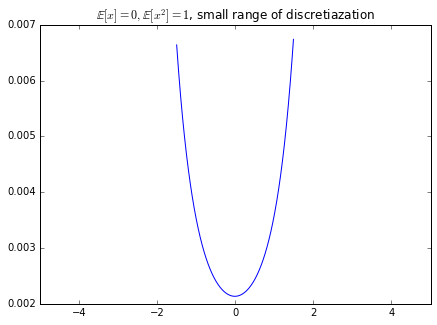

In [4]:
x2 = np.arange(-1.5, 1.5, .01)
a2 = np.array([x2, x2*x2])
q2 = np.ones(np.size(x2))
dual2 = me.MaxEntDual(q2, a2, u, e)

figure(figsize=[7, 5])
res2 = minimize(dual2.dual, np.zeros(len(u)), jac=dual2.grad, method="BFGS")
plot(x2, dual2.dist(res2.x))
xlim(-5, 5)
title('$\mathbb{E}[x] = 0, \mathbb{E}[x^2] = 1$, small range of discretiazation');

**(3) & (4)** It is indeed log normal

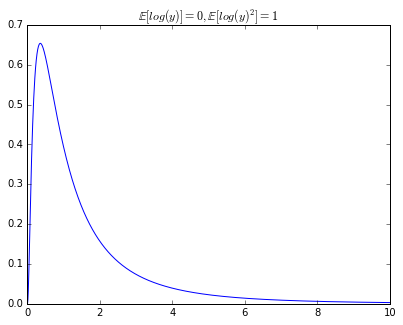

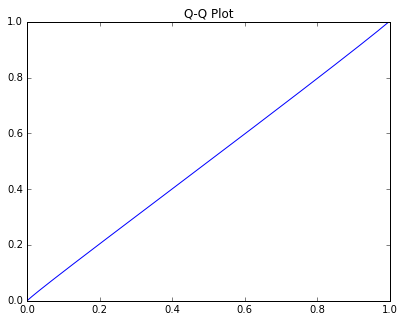

In [13]:
from scipy.stats import lognorm

dy = .01
y = np.arange(0.01, 16., dy)
x = log(y)
a = np.array([x, x*x])
u = np.array([0., 1.])
e = np.array([0., 0.])
q = np.ones(np.size(x))
dual3 = me.MaxEntDual(q, a, u, e)

figure(figsize=[6.5, 5])
res3 = minimize(dual3.dual, np.zeros(len(u)), jac=dual3.grad, method="BFGS")
plot(y, dual3.dist(res3.x)/dy)
xlim(0, 10)
title('$\mathbb{E}[log(y)] = 0, \mathbb{E}[log(y)^2] = 1$');


dual3_cdf = np.zeros(size(y))
for i in range(size(y)):
    dual3_cdf[i:] += dual3.dist(res3.x)[i]
    
figure(figsize=[6.5, 5])
lognorm_cdf = lognorm.cdf(y, s=1)
plot(lognorm_cdf, dual3_cdf)
ylim(0, 1)
title('Q-Q Plot');

**(5)** Adjust the prior distribution to be normal:

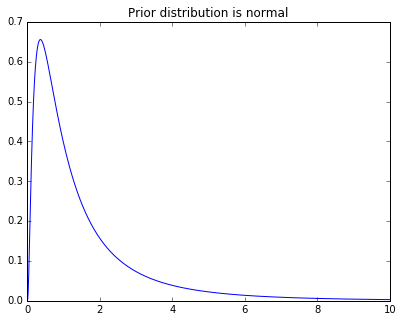

In [101]:
dy = .005
y = np.arange(0.001, 20., dy)
x = log(y)
a = np.array([x, x*x])
u = np.array([0., 1.])
e = np.array([0., 0.])
qn5 = norm.pdf(x)
dual5 = me.MaxEntDual(qn5, a, u, e)

figure(figsize=[6.5, 5])
res5 = minimize(dual5.dual, np.zeros(len(u)), jac=dual5.grad, method="BFGS")
plot(y, dual5.dist(res5.x)/dy)
xlim(0, 10)
title('Prior distribution is normal');

## Problem 2

Often times, we run into conflicting constraints in practice, 

1. try to solve the ME optimization with standard normal as the prior distribution, with the following conflicting skewness constraints of $E[x^3] = -2$ and $E[x^3] = 2$.  Show that the numerical optimizer will fail to find a solution if we don't allow error bounds (ie, like the bid/ask discussed in class); check your implementation so that it fails gracefully (i.e., it should not stop from running the rest of your ipython notebook cells when "Run All").
2. show that you can find a solution by introducing error bounds, and shift the distribution to skew left or right by adjusting the error bounds related to these donstraints.

This exercise illustrates that error bounds improve the robustness of the ME method.

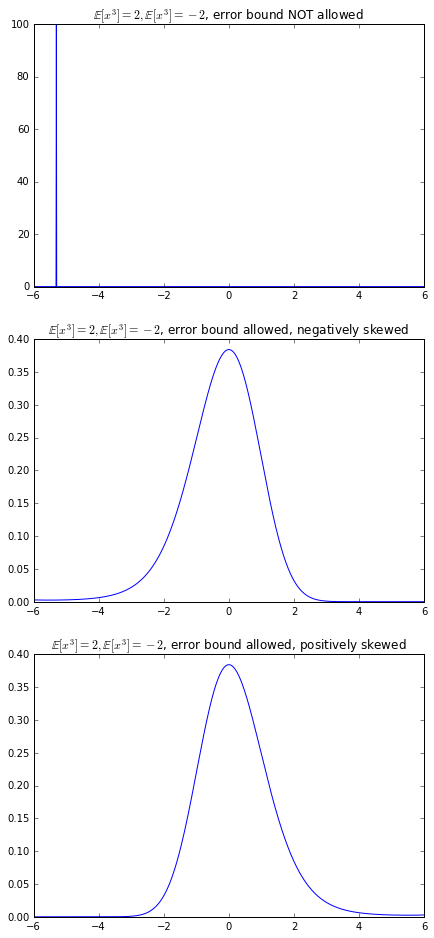

In [14]:
x = np.arange(-6., 6., dx)
a = np.array([x**3, x**3]) 
u = np.array([2, -2]) 

e0 = np.array([0, 0])
e1 = np.array([.1, 0.])
e2 = np.array([0., .1])

qn = norm.pdf(x) # prior belief

dual0 = me.MaxEntDual(qn, a, u, e0)
dual1 = me.MaxEntDual(qn, a, u, e1)
dual2 = me.MaxEntDual(qn, a, u, e2)

res0 = minimize(dual0.dual, np.zeros(len(u)), jac=dual0.grad, method="BFGS")
res1 = minimize(dual1.dual, np.zeros(len(u)), jac=dual1.grad, method="BFGS")
res2 = minimize(dual2.dual, np.zeros(len(u)), jac=dual2.grad, method="BFGS")

figure(figsize=[7, 16])
subplot(3,1,1)
plot(x, dual0.dist(res0.x)/dx)
#xlim(-5, 5)
title('$\mathbb{E}[x^3] = 2, \mathbb{E}[x^3] = -2$, error bound NOT allowed');
subplot(3,1,2)
plot(x, dual1.dist(res1.x)/dx)
#xlim(-5, 5)
title('$\mathbb{E}[x^3] = 2, \mathbb{E}[x^3] = -2$, error bound allowed, negatively skewed');
subplot(3,1,3)
plot(x, dual2.dist(res2.x)/dx)
#xlim(-5, 5)
title('$\mathbb{E}[x^3] = 2, \mathbb{E}[x^3] = -2$, error bound allowed, positively skewed');

## Problem 3

[open question] The asset allocation problem could be formulated as a maximum entropy optimization problem, if we view the dollar value of asset allocation as a distribution. Please give your thoughts on whether maximum entropy is a sensible objective function for solving the asset allocation problem. 

Hint: compare maximum entropy with the standard mean/variance method of asset allocation. Please give very short and concise answers. (this question can be anwsered in no more than 2 sentences).

### Solution

A portfolio allocation $\pi = (\pi_1, \pi_2,... , \pi_N)'$ among N risky assets, with properties $\pi_i ≥ 0$, $i = 1, 2,... , N$ and $\Sigma_{i=1}^N \pi_i = 1$, has the structure of a proper probability distribution. We will use the Entropy measure

$$ SE(\pi) = -\Sigma_{i=1}^N \pi_i \ln \pi_i$$

as a measure of portfolio diversification. ***When there is no other constraint, meaning when $\pi_i = 1/N$ for all $i$, $SE(\pi)$ has its maximum value $\ln N$***. Therefore, entropy that provides a good measure of disorder in a system or expected information in a probability distribution, can be taken as a measure of portfolio diversification. We put the entropy itself in the objective function so as to obtain maximum diversity in a portfolio allocation. It is clear that ***when we maximize $SE(\pi)$, we shrink the portfolio towards an equally weighted portfolio***. Thus maximum entropy is a sensible objective function for solving the asset allocation problem.

## Problem 4

A classic problem of Shapley allocation is the glove game, where three players A, B, C each has a single glove of left, left and right hand. Assuming that one pair of gloves with left and right hand worth $1, and unpaired gloves are worthless. 

1. apply Shapley allocation to divide the \$1 total value among the three players, by listing all possible permutations and take the average.
2. can you compute the stand-alone or Euler allocation for this game?
3. suppose B and C belongs to the same team, and A belongs to a different team, compute the allocation between two teams of [A] and [BC] using both Shapley and Constrained Shapley; comment on which allocation gives more sensible results. 
4. Repeat 3, but this time A and B (the two left hands) formed a team, while C is on his own. How does the results change?
5. derive the general case with 1 right glove and $n$ left goves, derive the allocation to the right hand glove under following two cases:
  1. no teams, under Shapley allocation
  2. all the $n$ left hands formed a term, under C-Shapley allocation
6. [open question] comment on whether fairness depends on organization

Hints:
* For #1: since the number of players are small, you can enumerate all possible permutations.
* For #5A: you only need to consider all the positions the right hand glove can appear amongst the $n$ left gloves, and the incremental contribution of the right hand glove at each position.

**(1)**  A and B have left-hand gloves and C has right-hand glove. Thus,

The value function is $V(S) = 1\$ $ only when $S \in \{\{A, C\}, \{B, C\}, \{A, B, C\}\}$ , otherwise $V(S) = 0$. (Notations come from [wikipedia](https://en.wikipedia.org/wiki/Shapley_value))

| Permutations | Cumulative value | A | B | C |
| :---: | :---: | :---: | :---: | :---: |
| A, B, C | 0, 0, 1 | 0 | 0 | 1 |  
| A, C, B | 0, 1, 0 | 0 | 0 | 1 | 
| B, C, A | 0, 1, 0 | 0 | 0 | 1 |
| C, B, A | 0, 1, 0 | 0 | 1 | 0 |
| B, A, C | 0, 0, 1 | 0 | 0 | 1 |
| C, A, B | 0, 1, 0 | 1 | 0 | 0 |
|| **Averages** | 1/6 |	1/6 |	2/3 |

**(2)**
No stand-alone allocation since each single player with one glove has **zero** value independently.

For Euler Allocation, note that $\frac{d}{dx} V(S)$ is always $0$ for any $S$, meaning we cannot obtain the result as well.

**(3)** B and C as a team:

| Permutations | Cumulative value | A | B | C |
| :---: | :---: | :---: | :---: | :---: |
| A, B, C | 0, 0, 1 | 0 | 0 | 1 |  
| A, C, B | 0, 1, 0 | 0 | 0 | 1 | 
| B, C, A | 0, 1, 0 | 0 | 0 | 1 |
| C, B, A | 0, 1, 0 | 0 | 1 | 0 |
| B, <font color=red> A</font>, C | 0, 0, 1 | 0 | 0 | 1 |   Not Admissible
| C, <font color=red> A</font>, B | 0, 1, 0 | 1 | 0 | 0 |   Not Admissible
| **Averages** | **of all**|	1/6 |	1/6 |	2/3 |
| **Averages** | **of admissibles** | 0 | 1/4 | 3/4 |


| | allocation to [A] | allocation to [BC] |
| :---:| :---:| :---:
| Shapley | 1/6 | 5/6 |
| C-Shapley | 0 | 1 |

**Comment: ** The C-Sharpley allocation gives a more sensible result. Since the right hand and left hand in the team have already made a pair, they directly contribute the value $1$ while the individual player A does not contribute any value.

**(4)** B and A as a team:

| Permutations | Cumulative value | A | B | C |
| :---: | :---: | :---: | :---: | :---: |
| A, B, C | 0, 0, 1 | 0 | 0 | 1 |  
| A, <font color=red> C</font>, B | 0, 1, 0 | 0 | 0 | 1 | Not Admissible
| B, <font color=red> C</font>, A | 0, 1, 0 | 0 | 0 | 1 | Not Admissible
| C, B, A | 0, 1, 0 | 0 | 1 | 0 |
| B, A, C | 0, 0, 1 | 0 | 0 | 1 |
| C, A, B | 0, 1, 0 | 1 | 0 | 0 |
| **Averages** | **of all**|	1/6 |	1/6 |	2/3 |
| **Averages** | **of admissibles** | 1/4 | 1/4 | 1/2 |

| | allocation to [AB] | allocation to [C] |
| :---:| :---:| :---:
| Shapley | 1/3 | 2/3 |
| C-Shapley | 1/2 | 1/2 |

**Comment: ** It's intuitive that since all players in the team (A&B) both have left hands while the individual player (C) has right hand, they should share the same fraction of allocation.

**(5)** When there are $1$ right-hand golve and $n$ left-hand gloves, total number of permutation is $(1+n)!$. 

**(A)** No teams, under Shapley allocation: left hand makes contribution only in the case that: right hand comes first and it directly follows. Then it's evident that the allocation for each player with left glove is 

$$\frac{1}{(1+n)!}$$ 

and the allocation for the right glove player is one minus the total contribution of each left hand, which is then

$$ 1-\frac{n}{(1+n)!}$$

**(B)** All the $n$ left hands formed a team, under C-Shapley allocation:

It's evident that the team and the right-hand glove both share $1/2$ of the allocation. And there are $n!$ permutations within the team of which each one has equal allocation by symmetry. 

**(6)** Fairness depends on organization. If we combine all left hands as a team, then it together shares the same proportion of conribution as the only right hand. But if we do not form any team, the proportion shared by each left hand is much smaller. The truly fairness of allocation depends on how we view this condition.